# GAN

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
# 하이퍼파라미터
EPOCHS = 200
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = get_default_device()
print("다음 장치를 사용합니다:", DEVICE)

다음 장치를 사용합니다: cuda


In [4]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST('./.data',
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, ), (0.5, ))
                                ]))
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data\FashionMNIST\raw



In [5]:
# 생성자 (Generator)
G = nn.Sequential(nn.Linear(64, 256), 
                  nn.ReLU(), 
                  nn.Linear(256, 256),
                  nn.ReLU(), 
                  nn.Linear(256, 784), 
                  nn.Tanh())

In [6]:
# 판별자 (Discriminator)
D = nn.Sequential(nn.Linear(784, 256), 
                  nn.LeakyReLU(0.2), 
                  nn.Linear(256, 256),
                  nn.LeakyReLU(0.2), 
                  nn.Linear(256, 1), 
                  nn.Sigmoid())

In [7]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

In [8]:
# 이진 교차 엔트로피 오차 함수
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [9]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #생성자가 판별자를 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
         .format(epoch, EPOCHS, d_loss.item(), g_loss.item(),
                real_score.mean().item(), fake_score.mean().item()))
        

이폭 [0/200] d_loss:0.0494 g_loss: 5.1206 D(x):0.98 D(G(z)):0.02
이폭 [1/200] d_loss:0.0321 g_loss: 5.2767 D(x):0.99 D(G(z)):0.02
이폭 [2/200] d_loss:0.0111 g_loss: 7.1244 D(x):1.00 D(G(z)):0.01
이폭 [3/200] d_loss:0.0268 g_loss: 6.3927 D(x):0.99 D(G(z)):0.02
이폭 [4/200] d_loss:0.1181 g_loss: 5.1008 D(x):0.98 D(G(z)):0.02
이폭 [5/200] d_loss:0.1708 g_loss: 4.0666 D(x):0.95 D(G(z)):0.03
이폭 [6/200] d_loss:0.0708 g_loss: 5.2116 D(x):0.98 D(G(z)):0.04
이폭 [7/200] d_loss:0.1519 g_loss: 5.7075 D(x):0.94 D(G(z)):0.04
이폭 [8/200] d_loss:0.2024 g_loss: 8.0233 D(x):0.92 D(G(z)):0.00
이폭 [9/200] d_loss:0.1757 g_loss: 3.2770 D(x):0.96 D(G(z)):0.08
이폭 [10/200] d_loss:0.1934 g_loss: 6.3505 D(x):0.92 D(G(z)):0.02
이폭 [11/200] d_loss:0.2763 g_loss: 4.0247 D(x):0.94 D(G(z)):0.06
이폭 [12/200] d_loss:0.1949 g_loss: 3.9469 D(x):0.96 D(G(z)):0.10
이폭 [13/200] d_loss:0.0924 g_loss: 5.3915 D(x):0.98 D(G(z)):0.05
이폭 [14/200] d_loss:0.6085 g_loss: 3.9102 D(x):0.80 D(G(z)):0.04
이폭 [15/200] d_loss:0.3944 g_loss: 3.8191 D(x):0.86

이폭 [128/200] d_loss:0.9031 g_loss: 1.8745 D(x):0.71 D(G(z)):0.30
이폭 [129/200] d_loss:0.7533 g_loss: 1.8248 D(x):0.75 D(G(z)):0.22
이폭 [130/200] d_loss:0.6754 g_loss: 2.0139 D(x):0.76 D(G(z)):0.21
이폭 [131/200] d_loss:1.0704 g_loss: 1.7907 D(x):0.70 D(G(z)):0.35
이폭 [132/200] d_loss:0.8786 g_loss: 1.6667 D(x):0.69 D(G(z)):0.27
이폭 [133/200] d_loss:1.1195 g_loss: 1.2929 D(x):0.72 D(G(z)):0.36
이폭 [134/200] d_loss:1.0341 g_loss: 1.3144 D(x):0.71 D(G(z)):0.35
이폭 [135/200] d_loss:0.8528 g_loss: 1.5046 D(x):0.78 D(G(z)):0.33
이폭 [136/200] d_loss:0.7393 g_loss: 1.7349 D(x):0.75 D(G(z)):0.25
이폭 [137/200] d_loss:0.8917 g_loss: 1.7545 D(x):0.73 D(G(z)):0.31
이폭 [138/200] d_loss:0.8919 g_loss: 1.4749 D(x):0.71 D(G(z)):0.31
이폭 [139/200] d_loss:0.9206 g_loss: 1.7636 D(x):0.70 D(G(z)):0.29
이폭 [140/200] d_loss:0.9612 g_loss: 1.5425 D(x):0.69 D(G(z)):0.28
이폭 [141/200] d_loss:0.8323 g_loss: 1.7459 D(x):0.73 D(G(z)):0.31
이폭 [142/200] d_loss:0.8456 g_loss: 1.8528 D(x):0.68 D(G(z)):0.22
이폭 [143/200] d_loss:0.896

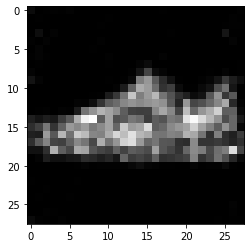

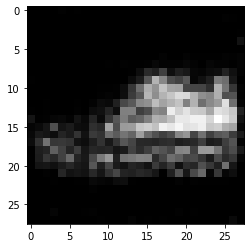

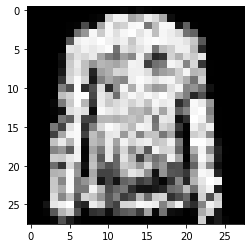

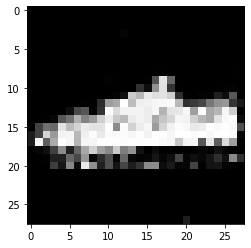

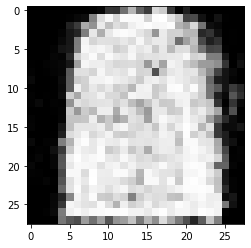

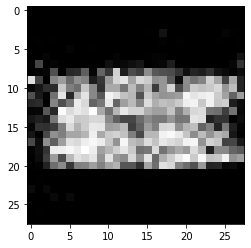

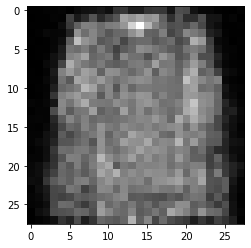

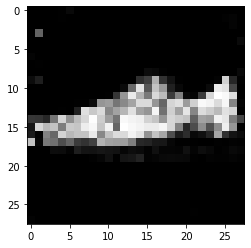

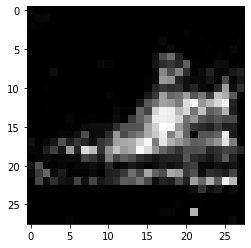

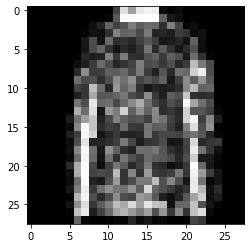

In [10]:
# 생성자가 만든 이미지 시각화하기
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

# cGAN

In [18]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [19]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [22]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 오차 함수
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [23]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산(데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss: {:.4f} g_loss: {:.4f} D(x): {:.2f} D(G(z)): {:.2f}'
         .format(epoch, EPOCHS, d_loss.item(), g_loss.item(),
                 real_score.mean().item(), fake_score.mean().item()))
    

이폭 [0/200] d_loss: 0.1407 g_loss: 7.3440 D(x): 0.94 D(G(z)): 0.04
이폭 [1/200] d_loss: 0.3385 g_loss: 4.1454 D(x): 0.87 D(G(z)): 0.08
이폭 [2/200] d_loss: 0.4569 g_loss: 3.2238 D(x): 0.89 D(G(z)): 0.13
이폭 [3/200] d_loss: 0.2530 g_loss: 4.7598 D(x): 0.91 D(G(z)): 0.07
이폭 [4/200] d_loss: 0.6468 g_loss: 3.1040 D(x): 0.82 D(G(z)): 0.21
이폭 [5/200] d_loss: 0.5849 g_loss: 2.2895 D(x): 0.83 D(G(z)): 0.21
이폭 [6/200] d_loss: 0.7180 g_loss: 2.1719 D(x): 0.81 D(G(z)): 0.22
이폭 [7/200] d_loss: 0.8029 g_loss: 1.9830 D(x): 0.81 D(G(z)): 0.29
이폭 [8/200] d_loss: 0.9040 g_loss: 1.8434 D(x): 0.71 D(G(z)): 0.28
이폭 [9/200] d_loss: 0.8108 g_loss: 1.8146 D(x): 0.80 D(G(z)): 0.29
이폭 [10/200] d_loss: 0.9046 g_loss: 1.8477 D(x): 0.71 D(G(z)): 0.29
이폭 [11/200] d_loss: 0.4707 g_loss: 2.3894 D(x): 0.84 D(G(z)): 0.18
이폭 [12/200] d_loss: 0.8313 g_loss: 1.6904 D(x): 0.74 D(G(z)): 0.28
이폭 [13/200] d_loss: 0.8795 g_loss: 1.5427 D(x): 0.74 D(G(z)): 0.32
이폭 [14/200] d_loss: 0.7759 g_loss: 1.6325 D(x): 0.76 D(G(z)): 0.27
이폭 [1

이폭 [123/200] d_loss: 1.1240 g_loss: 0.9394 D(x): 0.63 D(G(z)): 0.42
이폭 [124/200] d_loss: 1.1160 g_loss: 1.1052 D(x): 0.62 D(G(z)): 0.39
이폭 [125/200] d_loss: 1.1965 g_loss: 0.9585 D(x): 0.59 D(G(z)): 0.41
이폭 [126/200] d_loss: 1.3351 g_loss: 0.9362 D(x): 0.59 D(G(z)): 0.46
이폭 [127/200] d_loss: 1.2498 g_loss: 1.1081 D(x): 0.57 D(G(z)): 0.38
이폭 [128/200] d_loss: 1.1747 g_loss: 0.9731 D(x): 0.61 D(G(z)): 0.43
이폭 [129/200] d_loss: 1.3949 g_loss: 1.0078 D(x): 0.51 D(G(z)): 0.40
이폭 [130/200] d_loss: 1.1725 g_loss: 1.0808 D(x): 0.57 D(G(z)): 0.36
이폭 [131/200] d_loss: 1.3218 g_loss: 0.8927 D(x): 0.53 D(G(z)): 0.44
이폭 [132/200] d_loss: 1.3033 g_loss: 0.7567 D(x): 0.57 D(G(z)): 0.49
이폭 [133/200] d_loss: 1.2991 g_loss: 1.1694 D(x): 0.52 D(G(z)): 0.37
이폭 [134/200] d_loss: 1.0413 g_loss: 0.9776 D(x): 0.64 D(G(z)): 0.41
이폭 [135/200] d_loss: 1.3072 g_loss: 1.0105 D(x): 0.54 D(G(z)): 0.42
이폭 [136/200] d_loss: 1.3889 g_loss: 1.1350 D(x): 0.53 D(G(z)): 0.38
이폭 [137/200] d_loss: 1.2452 g_loss: 0.8395 D(x):

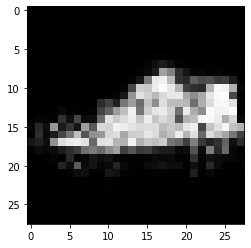

In [24]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 7 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)

sample_images = G(z, g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0], (28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()